In [1]:
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
gitt1 = pd.read_csv('gitt1.csv')

In [ ]:
plt.plot(gitt1['TestTime'], gitt1['Voltage/V'])
plt.plot(gitt1['TestTime'], gitt1[''])

In [12]:
gitt1['TestTime'][0].split('-')

AttributeError: 'list' object has no attribute 'split'

In [13]:
gitt1['TestTime'][1].split(':')

['0', '01', '00']

In [27]:
gitt1['TestTime'][10000].split('-')

['4', '06:21:07']

In [28]:
24*3600

86400

In [30]:
gitt1['TestTime'][10000].split('-')[1]

'06:21:07'

In [35]:
'-' not in gitt1['TestTime'][i].split('-')

True

In [41]:
# Cleaning up Kevin's Data

time = np.zeros(len(gitt1['TestTime']))

for i in range(len(gitt1['TestTime'])):
    if '-' not in gitt1['TestTime'][i]:
        hr = float(gitt1['TestTime'][i].split(':')[0]) * 3600
        mins = float(gitt1['TestTime'][i].split(':')[1]) * 60
        sec = float(gitt1['TestTime'][i].split(':')[2])
        time[i] = hr + mins + sec
    if '-' in gitt1['TestTime'][i]:
        #print(gitt1['TestTime'][i].split('-'))
        day = float(gitt1['TestTime'][i].split('-')[0])*86400
        idx2 = gitt1['TestTime'][i].split('-')[1]
        hr = float(idx2.split(':')[0]) * 3600
        mins = float(idx2.split(':')[1]) * 60
        sec = float(idx2.split(':')[2])
        time[i] = day + hr + mins+ sec

In [45]:
gitt1['Time(s)'] = pd.Series(time)

In [62]:
gitt1.tail()

,TestTime,Voltage/V,Current/mA,Time(s)
69529,13-03:31:35,1.7256,0.0,1135895.0
69530,13-03:32:35,1.7246,0.0,1135955.0
69531,13-03:33:35,1.7240,0.0,1136015.0
69532,13-03:34:35,1.7246,0.0,1136075.0
69533,13-03:35:35,1.7243,0.0,1136135.0


In [57]:
time = np.array(gitt1['Time(s)'])
voltage = np.array(gitt1['Voltage/V'])
current = np.array(gitt1['Current/mA'])

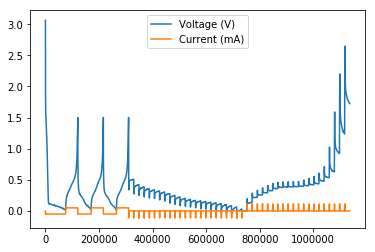

In [60]:
plt.plot(time, voltage, label = 'Voltage (V)')
plt.plot(time, current, label = 'Current (mA)')
plt.legend()
plt.show()

In [ ]:
for i in range(len(current)):
    

In [64]:
workingcurrent = np.argwhere(current != 0)

workingcurrent[i + 1] - workingcurrent

In [73]:
d = {}
startidx = int(workingcurrent[0])
cycle = 1

for i in range(len(workingcurrent)-1):
    if workingcurrent[i + 1] - workingcurrent[i] != 1:
        endidx = int(workingcurrent[i +1] - 1)
        d[cycle] = gitt1[startidx:endidx]
        
        startidx = int(workingcurrent[i +1])
        cycle = cycle + 1
                       

In [87]:
d.keys() # Ignore first key, just full charge/discharge cycles

dict_keys([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43])

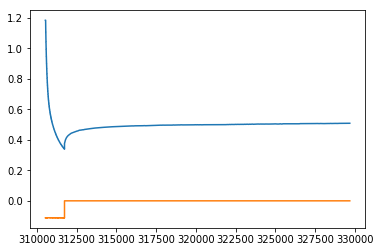

In [88]:
i = 2
plt.plot(d[i]['Time(s)'], d[i]['Voltage/V'])
plt.plot(d[i]['Time(s)'], d[i]['Current/mA'])

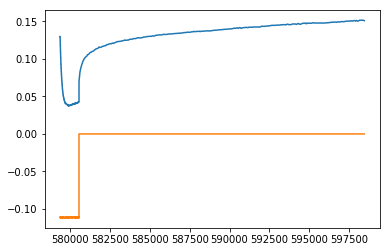

In [89]:
i = 16
plt.plot(d[i]['Time(s)'], d[i]['Voltage/V'])
plt.plot(d[i]['Time(s)'], d[i]['Current/mA'])

In [67]:
len(current)

69534

In [61]:
4*86400

345600

In [ ]:
525600 # min / year